In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Load dataset
df = pd.read_csv("/content/full_preprocessed_aqi_weather_data.csv")
df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True)

In [ ]:
# Set datetime index for time-based plots
df.set_index("datetime", inplace=True)

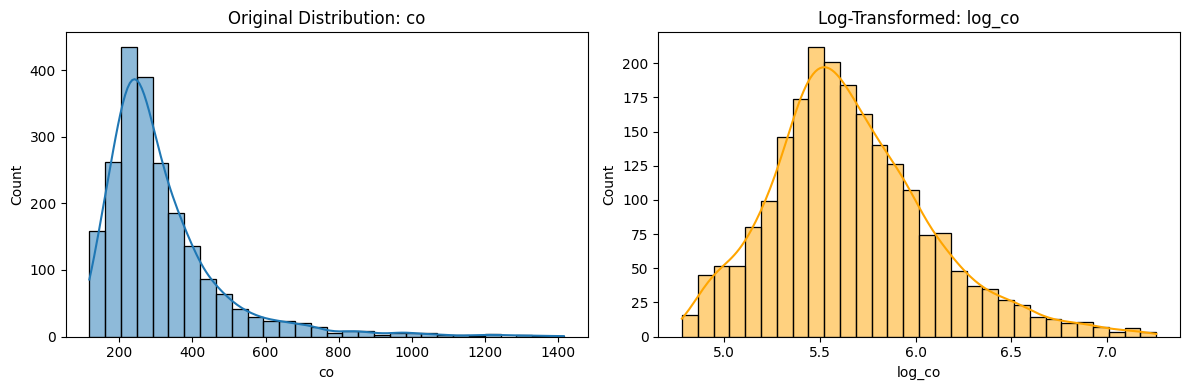

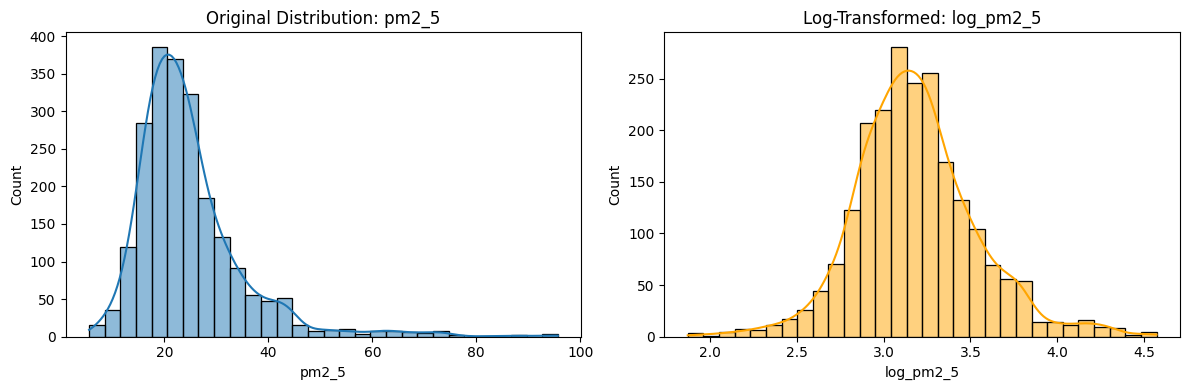

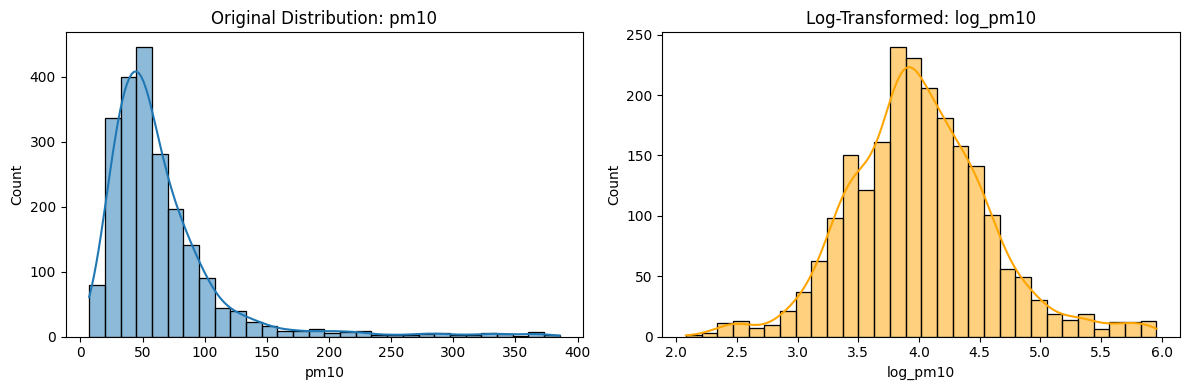

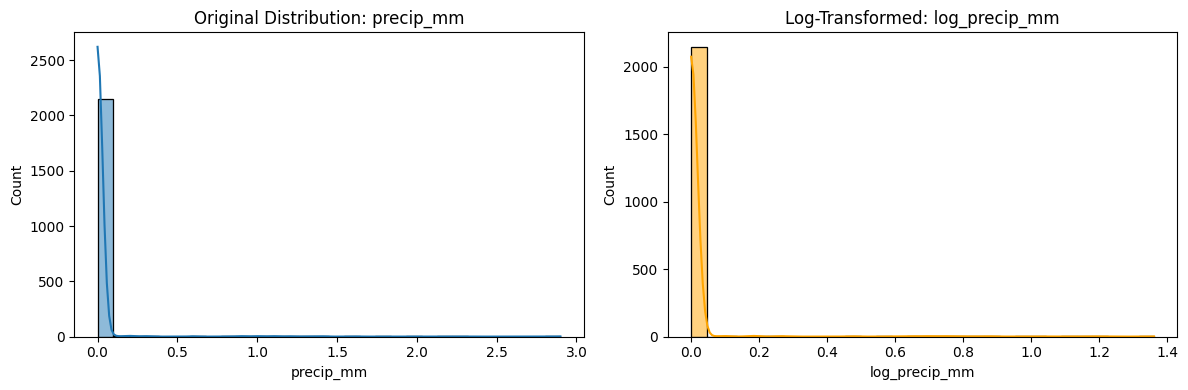

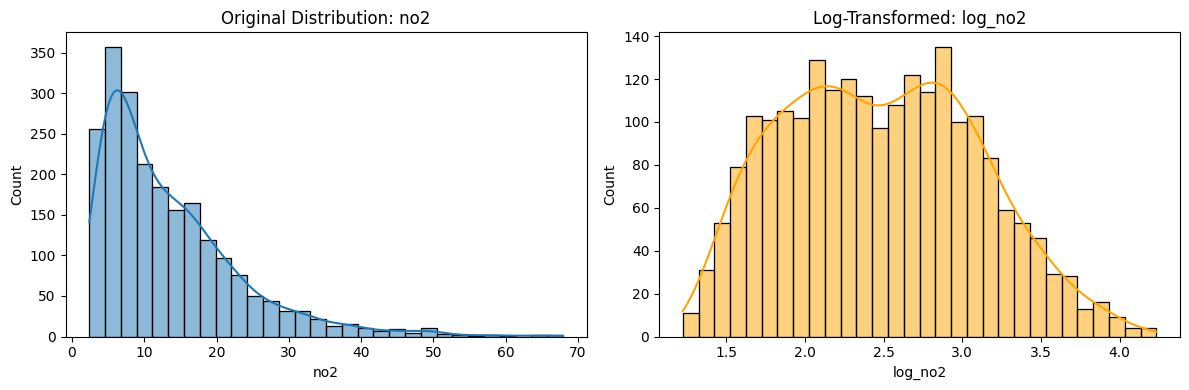

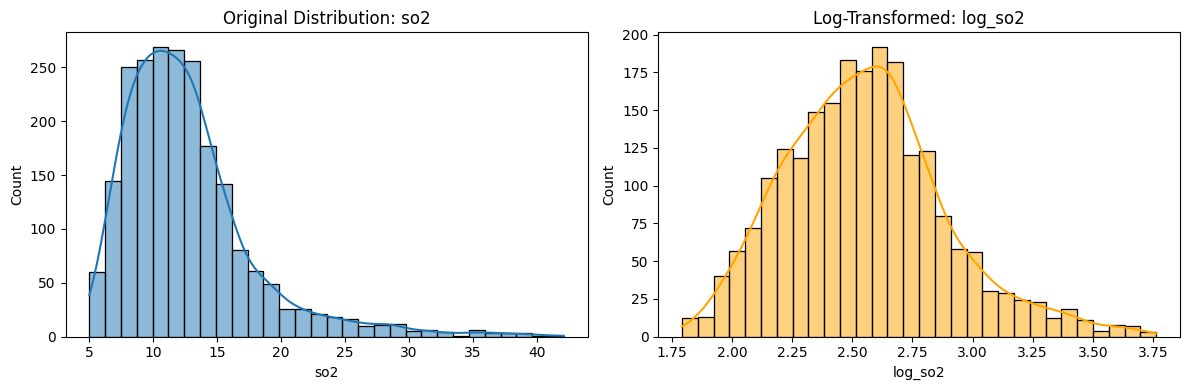

In [ ]:
# --- 1. Distribution Histograms: Original vs Log-transformed ---
features = ["co", "pm2_5", "pm10", "precip_mm", "no2", "so2"]
for col in features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f"Original Distribution: {col}")
    sns.histplot(df[f"log_{col}"], bins=30, kde=True, ax=axes[1], color='orange')
    axes[1].set_title(f"Log-Transformed: log_{col}")
    plt.tight_layout()
    plt.show()

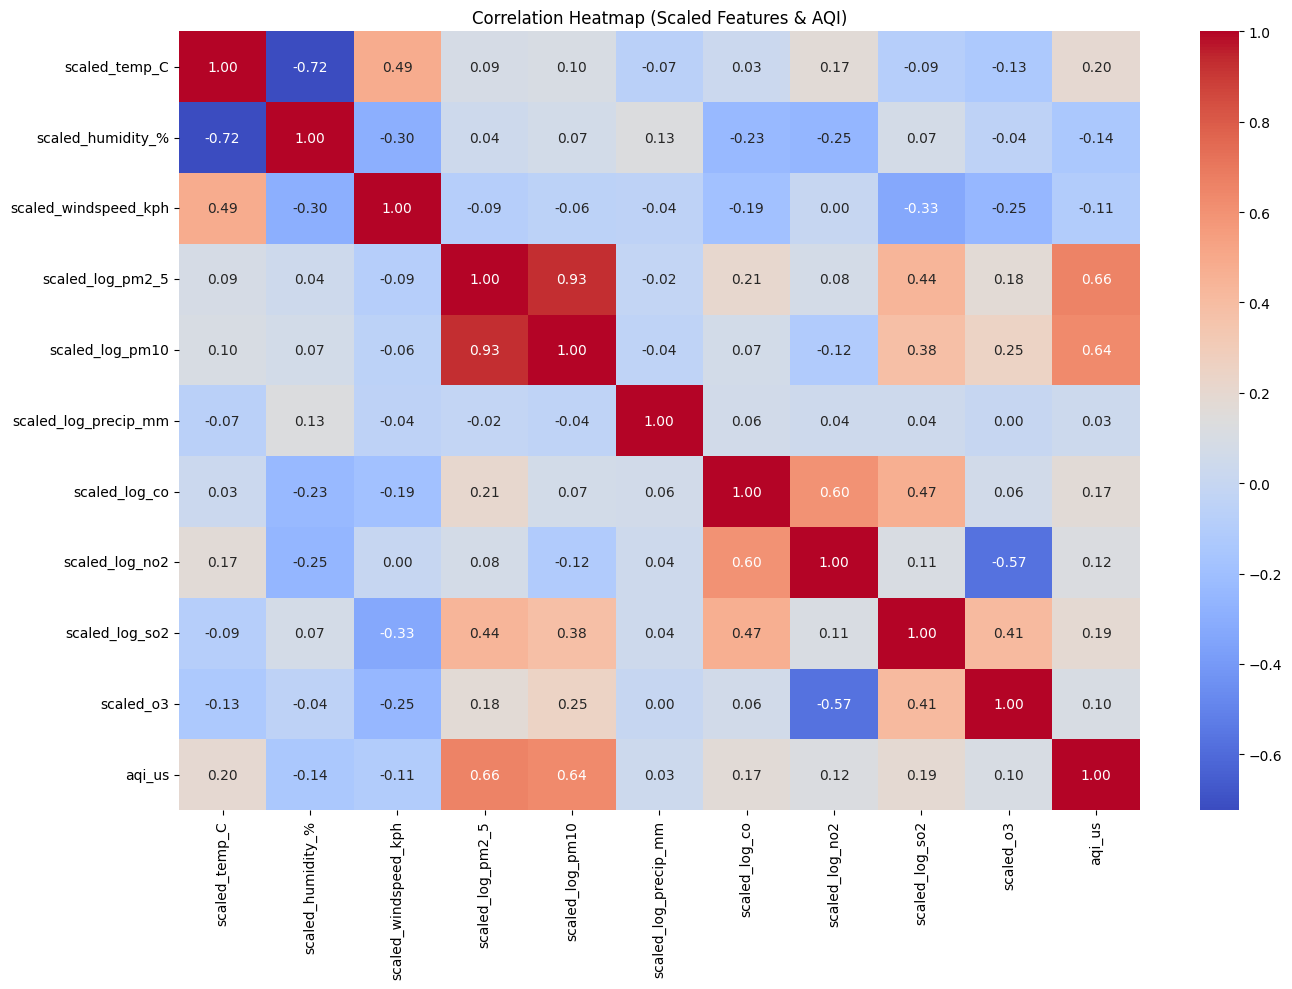

In [ ]:
# --- 2. Correlation Heatmap: Using scaled features + aqi_us ---
scaled_cols = [col for col in df.columns if col.startswith("scaled_")]
plt.figure(figsize=(14, 10))
sns.heatmap(df[scaled_cols + ["aqi_us"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Scaled Features & AQI)")
plt.tight_layout()
plt.show()

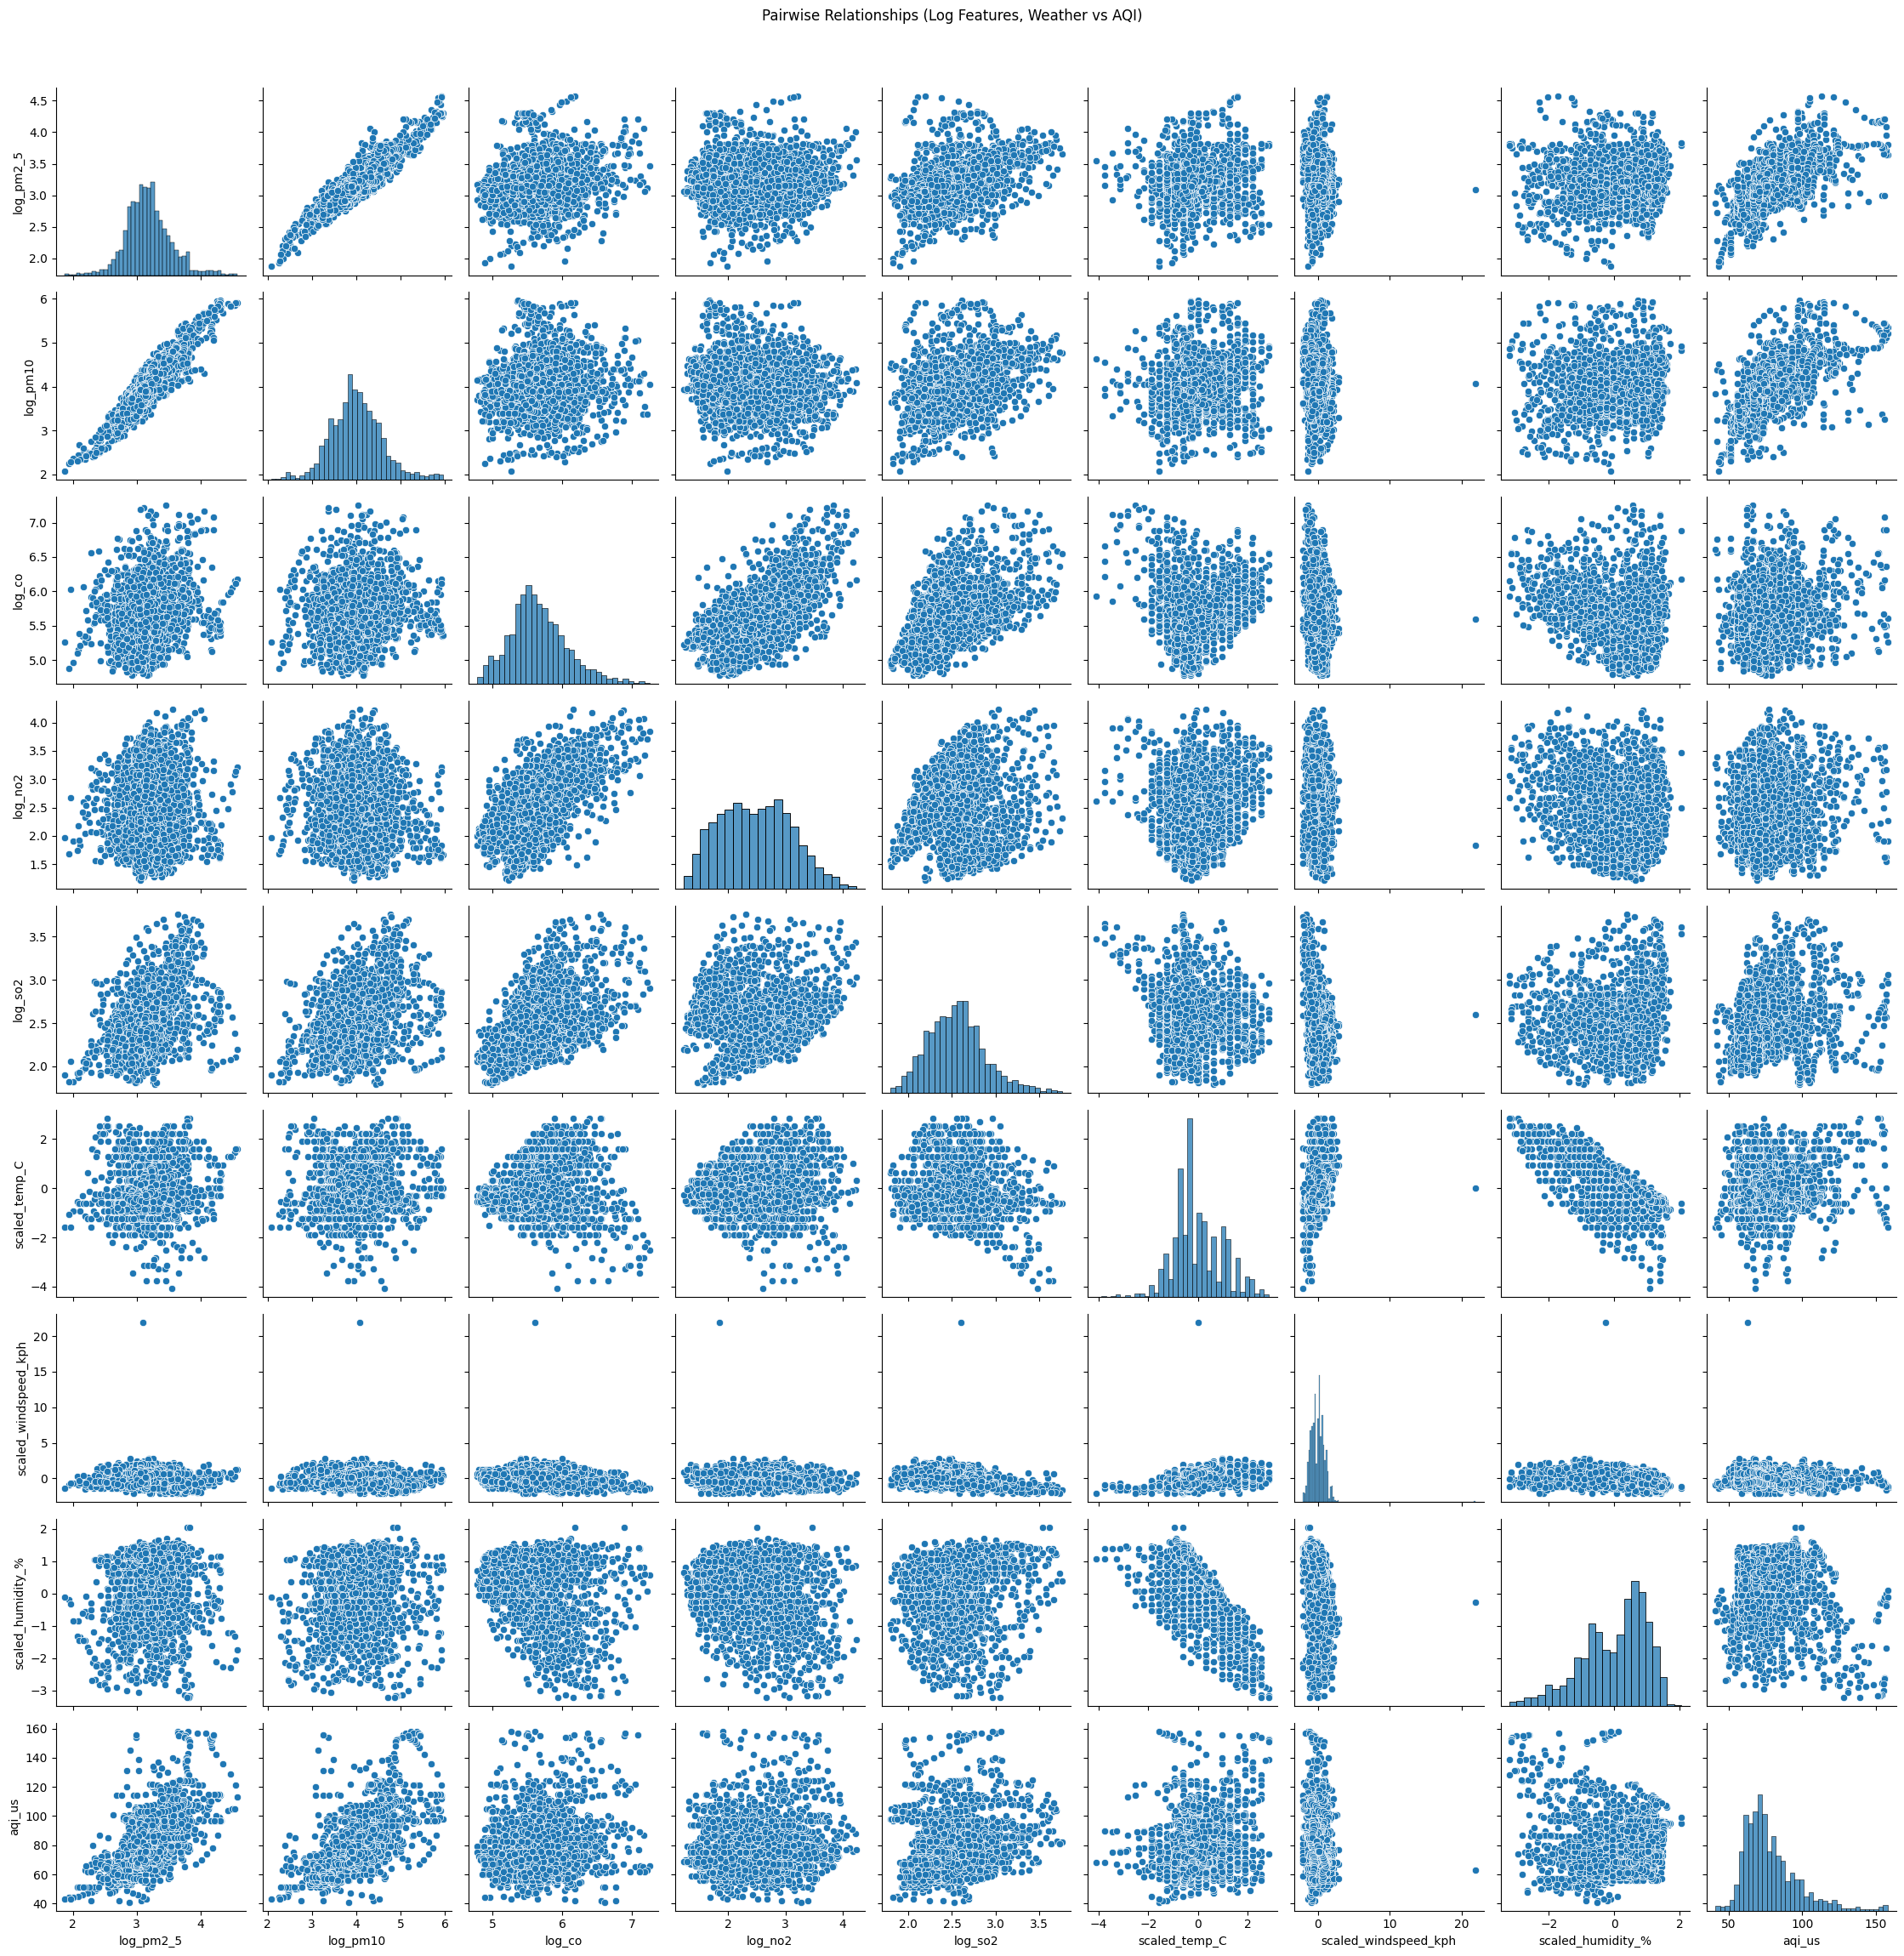

In [ ]:
# --- 3. Pairplot (log-transformed vs AQI) ---

# Select the columns: log-transformed pollutants, weather variables, and aqi_us
columns_to_plot = ["log_pm2_5", "log_pm10", "log_co", "log_no2", "log_so2",
                   "scaled_temp_C", "scaled_windspeed_kph", "scaled_humidity_%", "aqi_us"]

# Create the pairplot
sns.pairplot(df[columns_to_plot])
plt.suptitle("Pairwise Relationships (Log Features, Weather vs AQI)", y=1.02)
plt.tight_layout()
plt.show()

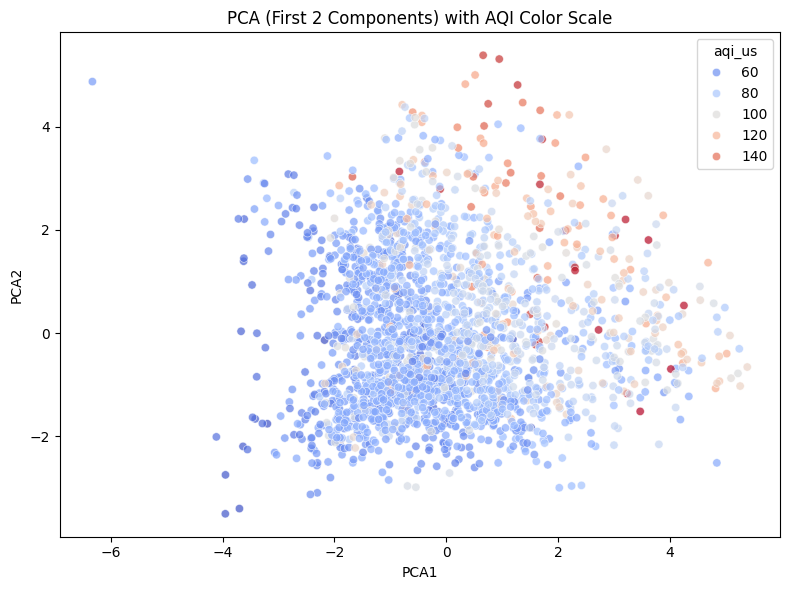

In [ ]:
# --- 4. PCA Visualization ---
from sklearn.preprocessing import StandardScaler
pca_features = df[scaled_cols]
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_features)
df["PCA1"], df["PCA2"] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="aqi_us", palette="coolwarm", alpha=0.7)
plt.title("PCA (First 2 Components) with AQI Color Scale")
plt.tight_layout()
plt.show()

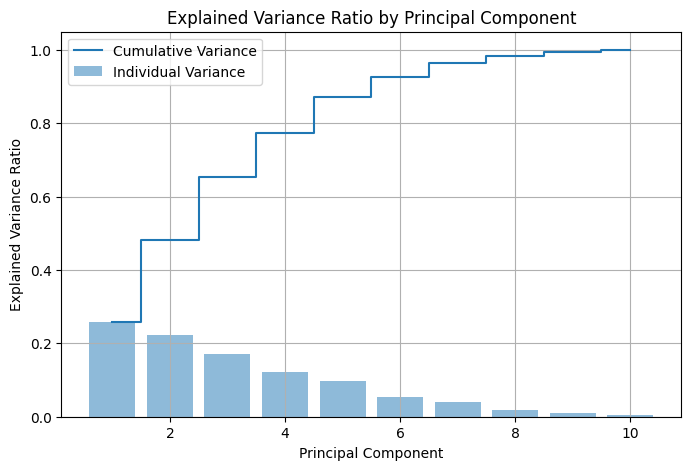

Explained Variance Ratio per Component: [0.25905128 0.22239666 0.17211065 0.12079698 0.09770754 0.05445942
 0.03920503 0.01836315 0.01124266 0.00466663]
Cumulative Explained Variance Ratio: [0.25905128 0.48144795 0.65355859 0.77435558 0.87206311 0.92652253
 0.96572756 0.98409071 0.99533337 1.        ]


In [ ]:
# Select scaled features for PCA
scaled_cols = [col for col in df.columns if col.startswith("scaled_")]
pca_features = df[scaled_cols]

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(pca_features)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, label='Individual Variance')
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Cumulative Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.legend()
plt.grid()
plt.show()

# Print detailed variance
print("Explained Variance Ratio per Component:", explained_variance_ratio)
print("Cumulative Explained Variance Ratio:", cumulative_variance_ratio)



Top 5 Contributors to PCA1 (by absolute loading):
scaled_log_pm2_5        0.484555
scaled_log_so2          0.478318
scaled_log_pm10         0.472852
scaled_o3               0.339024
scaled_windspeed_kph    0.301648
Name: PCA1, dtype: float64

Top 5 Contributors to PCA2 (by absolute loading):
scaled_temp_C           0.501708
scaled_humidity_%       0.493196
scaled_log_no2          0.437729
scaled_log_co           0.361433
scaled_windspeed_kph    0.247804
Name: PCA2, dtype: float64


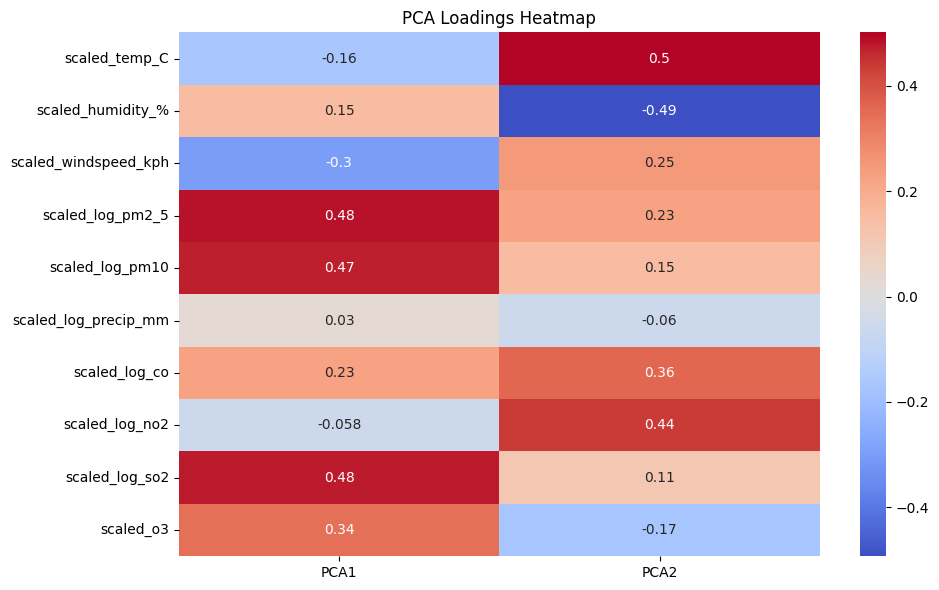

In [ ]:
# Select scaled features for PCA
scaled_cols = [col for col in df.columns if col.startswith("scaled_")]
pca_features = df[scaled_cols]

# Apply PCA with 2 components (consistent with visualization)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_features)

# Get the loadings (component weights) - transpose to match features with components
loadings = pd.DataFrame(pca.components_.T, columns=['PCA1', 'PCA2'], index=scaled_cols)

# Absolute loadings for easier interpretation
loadings_abs = loadings.abs()

# Sort by absolute loading to identify top contributors
top_loadings_pca1 = loadings_abs['PCA1'].sort_values(ascending=False).head(5)
top_loadings_pca2 = loadings_abs['PCA2'].sort_values(ascending=False).head(5)

# Print top contributors
print("Top 5 Contributors to PCA1 (by absolute loading):")
print(top_loadings_pca1)
print("\nTop 5 Contributors to PCA2 (by absolute loading):")
print(top_loadings_pca2)

# Visualize loadings with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings Heatmap')
plt.tight_layout()
plt.show()

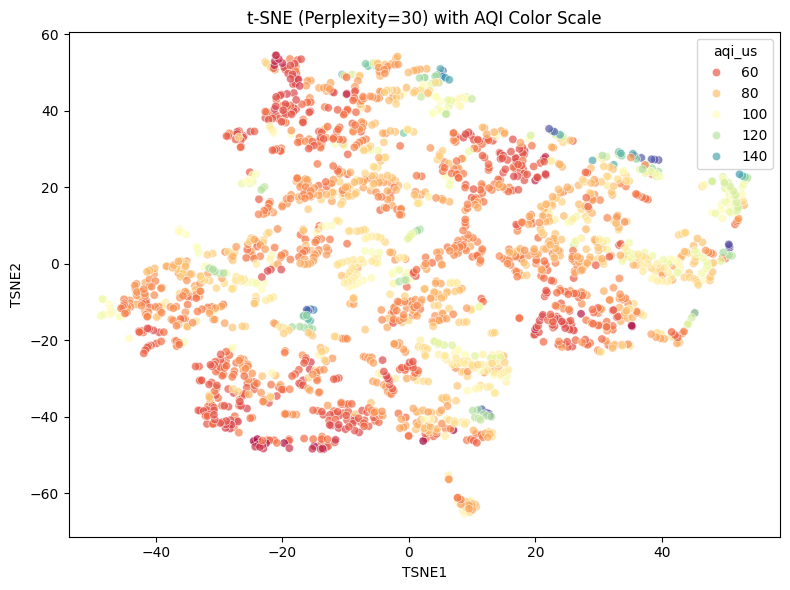

In [ ]:
# --- 5. t-SNE Visualization ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(pca_features)
df["TSNE1"], df["TSNE2"] = tsne_result[:, 0], tsne_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="aqi_us", palette="Spectral", alpha=0.7)
plt.title("t-SNE (Perplexity=30) with AQI Color Scale")
plt.tight_layout()
plt.show()

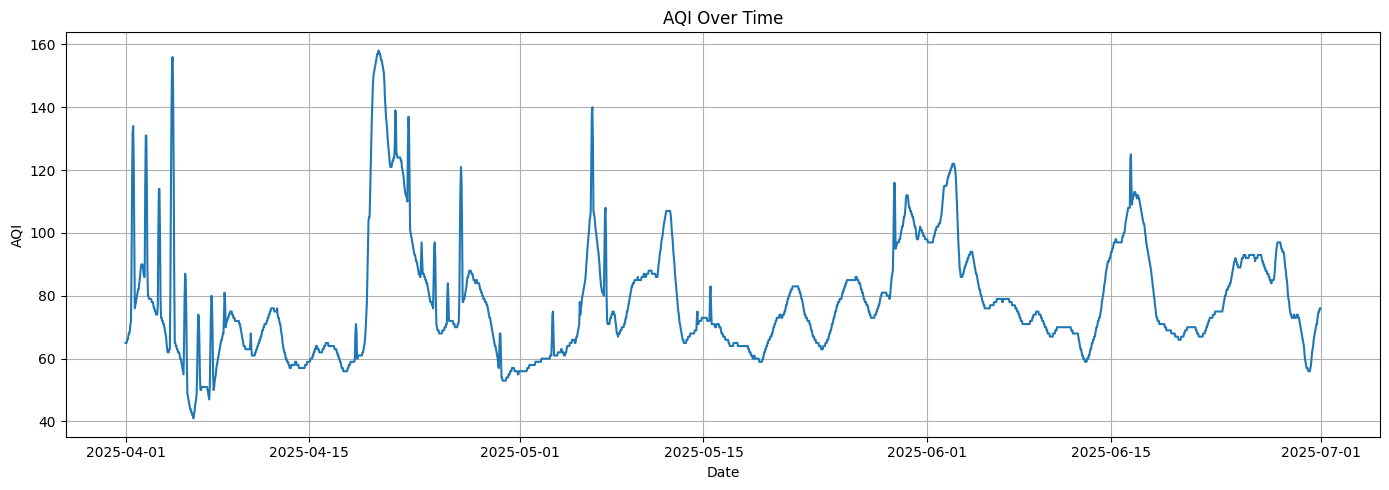

In [ ]:
# --- 6. AQI Over Time ---
plt.figure(figsize=(14, 5))
plt.plot(df.index, df["aqi_us"], label="AQI (US)")
plt.title("AQI Over Time")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.grid(True)
plt.tight_layout()
plt.show()

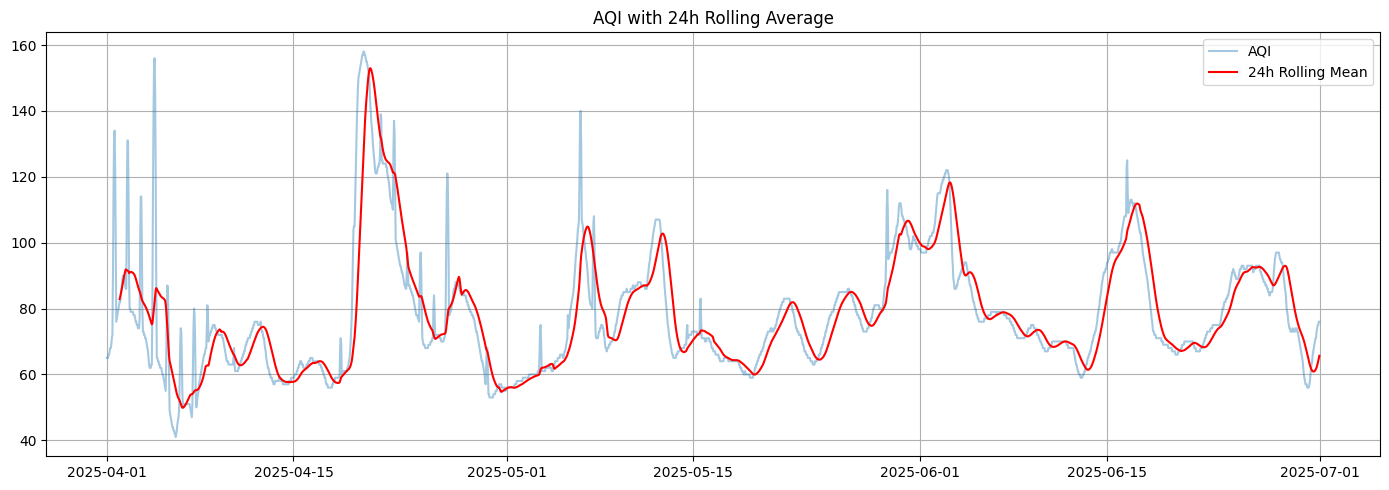

In [ ]:
# --- 7. Rolling Mean (24h) ---
df["aqi_rolling_24h"] = df["aqi_us"].rolling(24).mean()
plt.figure(figsize=(14, 5))
plt.plot(df.index, df["aqi_us"], label="AQI", alpha=0.4)
plt.plot(df.index, df["aqi_rolling_24h"], label="24h Rolling Mean", color='red')
plt.title("AQI with 24h Rolling Average")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

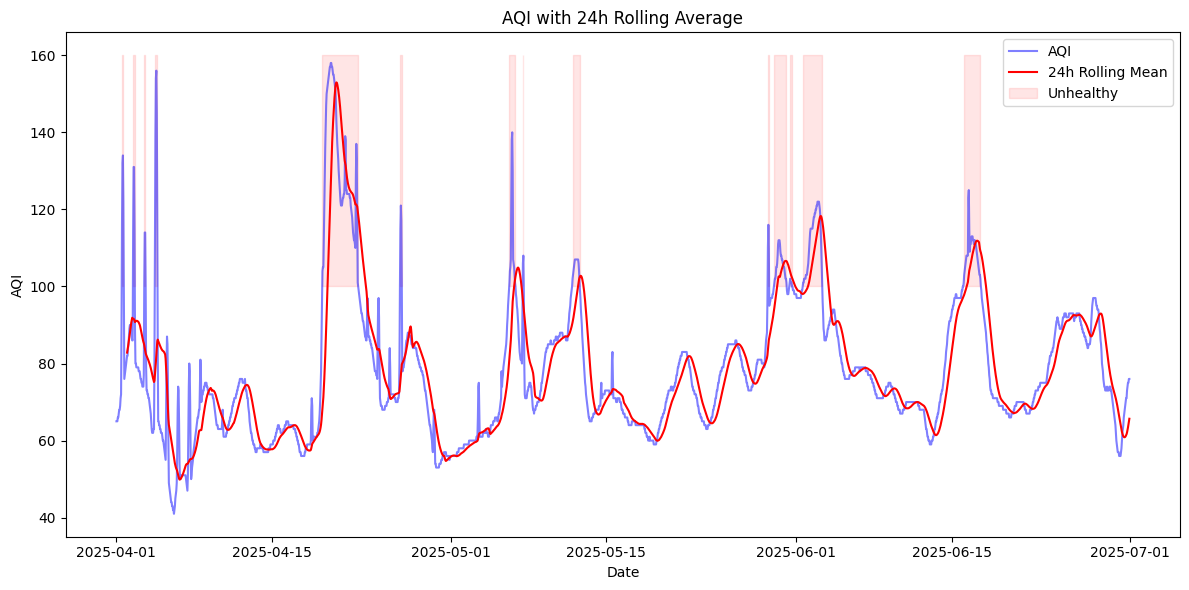

In [ ]:
# Assuming df has 'datetime' and 'aqi_us' columns
df['24h_rolling_mean'] = df['aqi_us'].rolling(window=24).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['aqi_us'], label='AQI', color='blue', alpha=0.5)
plt.plot(df.index, df['24h_rolling_mean'], label='24h Rolling Mean', color='red')
plt.fill_between(df.index, 100, 160, where=(df['aqi_us'] > 100), color='red', alpha=0.1, label='Unhealthy')
plt.title('AQI with 24h Rolling Average')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.tight_layout()
plt.show()

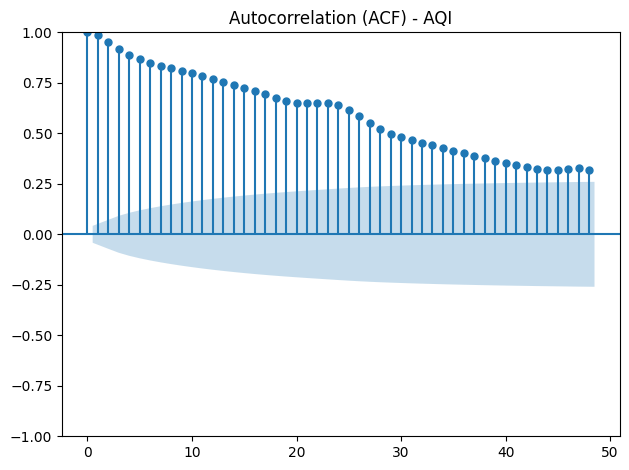

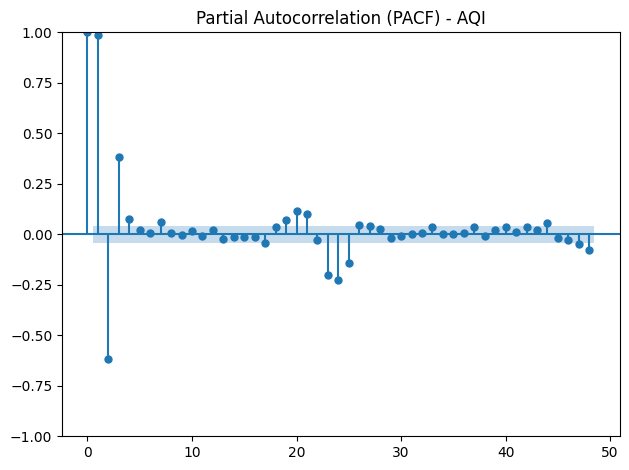

In [ ]:
# --- 8. ACF and PACF for AQI ---
plot_acf(df["aqi_us"], lags=48)
plt.title("Autocorrelation (ACF) - AQI")
plt.tight_layout()
plt.show()

plot_pacf(df["aqi_us"], lags=48)
plt.title("Partial Autocorrelation (PACF) - AQI")
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# SARIMA model (p=1, d=0, q=0, seasonal order=(0,0,0,24))
model = ARIMA(df['aqi_us'], order=(1, 0, 0), seasonal_order=(0, 0, 0, 24))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 aqi_us   No. Observations:                 2184
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5605.042
Date:                Wed, 02 Jul 2025   AIC                          11216.084
Time:                        00:22:56   BIC                          11233.151
Sample:                    04-01-2025   HQIC                         11222.323
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.2589      6.177     12.670      0.000      66.153      90.365
ar.L1          0.9853      0.003    317.170      0.000       0.979       0.991
sigma2         9.9069      0.075    132.553      0.0

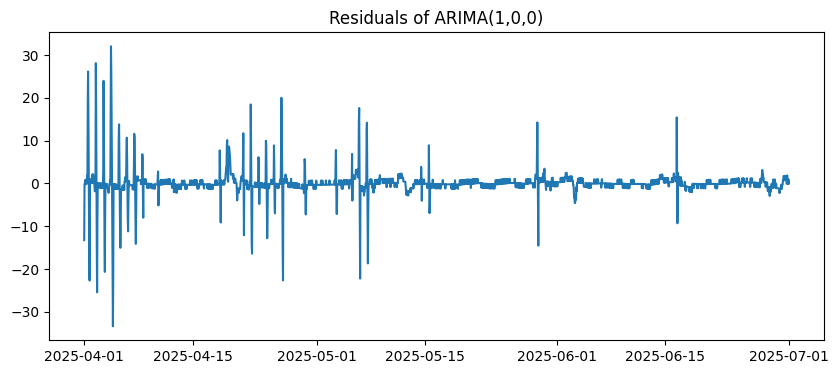

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(results.resid)
plt.title('Residuals of ARIMA(1,0,0)')
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                             aqi_us   No. Observations:                 2184
Model:             ARIMA(1, 0, 0)x(0, 0, [1], 24)   Log Likelihood               -5387.808
Date:                            Wed, 02 Jul 2025   AIC                          10783.616
Time:                                    00:28:23   BIC                          10806.372
Sample:                                04-01-2025   HQIC                         10791.935
                                     - 06-30-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.2682      6.479     12.081      0.000      65.570      90.966
ar.L1          0.9825      0.003   

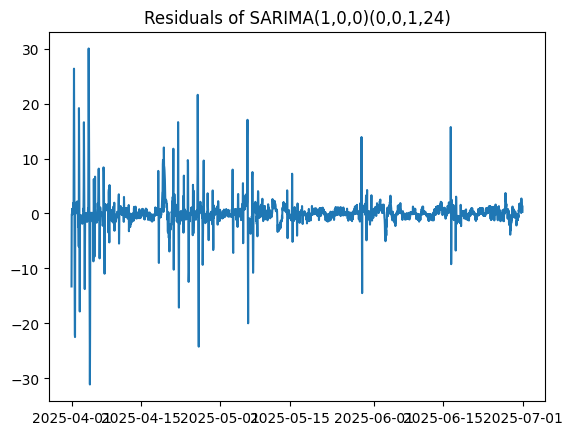

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['aqi_us'], order=(1, 0, 0), seasonal_order=(0, 0, 1, 24))
results = model.fit()
print(results.summary())
plt.plot(results.resid)
plt.title('Residuals of SARIMA(1,0,0)(0,0,1,24)')
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             aqi_us   No. Observations:                 2184
Model:             ARIMA(1, 0, 0)x(0, 0, [1], 24)   Log Likelihood               -5385.593
Date:                            Wed, 02 Jul 2025   AIC                          10787.186
Time:                                    00:28:57   BIC                          10832.697
Sample:                                04-01-2025   HQIC                         10803.823
                                     - 06-30-2025                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -25.1733    103.822     -0.242      0.808    -228.660     178.314
log_p

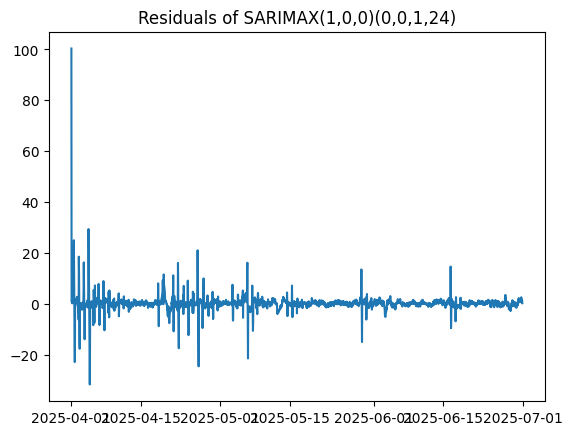

In [ ]:
exog = df[['log_pm2_5', 'log_pm10', 'scaled_windspeed_kph', 'scaled_humidity_%']]
model = ARIMA(df['aqi_us'], order=(1, 0, 0), seasonal_order=(0, 0, 1, 24), exog=exog)
results = model.fit()
print(results.summary())
plt.plot(results.resid)
plt.title('Residuals of SARIMAX(1,0,0)(0,0,1,24)')
plt.show()

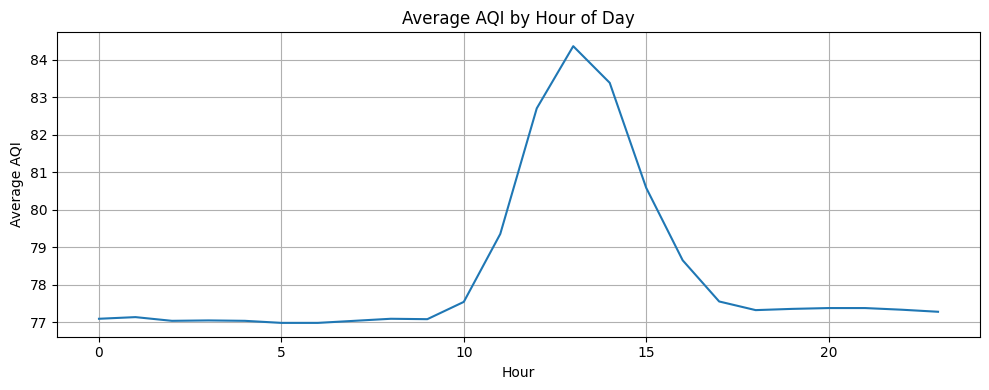

In [ ]:
# --- 9. Average AQI by Hour of Day ---
df["hour"] = df.index.hour
hourly_avg = df.groupby("hour")["aqi_us"].mean()
plt.figure(figsize=(10, 4))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title("Average AQI by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average AQI")
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
# Load dataset
df = pd.read_csv("/content/full_preprocessed_aqi_weather_data_with_lags.csv")

In [3]:
# Create interaction terms
df['log_pm2_5_scaled_windspeed_kph'] = df['log_pm2_5'] * df['scaled_windspeed_kph']
df['log_pm2_5_scaled_humidity_%'] = df['log_pm2_5'] * df['scaled_humidity_%']
df['scaled_temp_C_scaled_o3'] = df['scaled_temp_C'] * df['scaled_o3']

In [4]:
# Select features for correlation analysis (include selected RF/XGBoost features + interactions)
features_to_correlate = ['aqi_us', 'log_pm2_5', 'scaled_windspeed_kph', 'scaled_humidity_%',
                        'scaled_temp_C', 'scaled_o3', 'log_pm2_5_scaled_windspeed_kph',
                        'log_pm2_5_scaled_humidity_%', 'scaled_temp_C_scaled_o3']

In [5]:
# Calculate correlation matrix (Pearson by default)
correlation_matrix = df[features_to_correlate].corr()

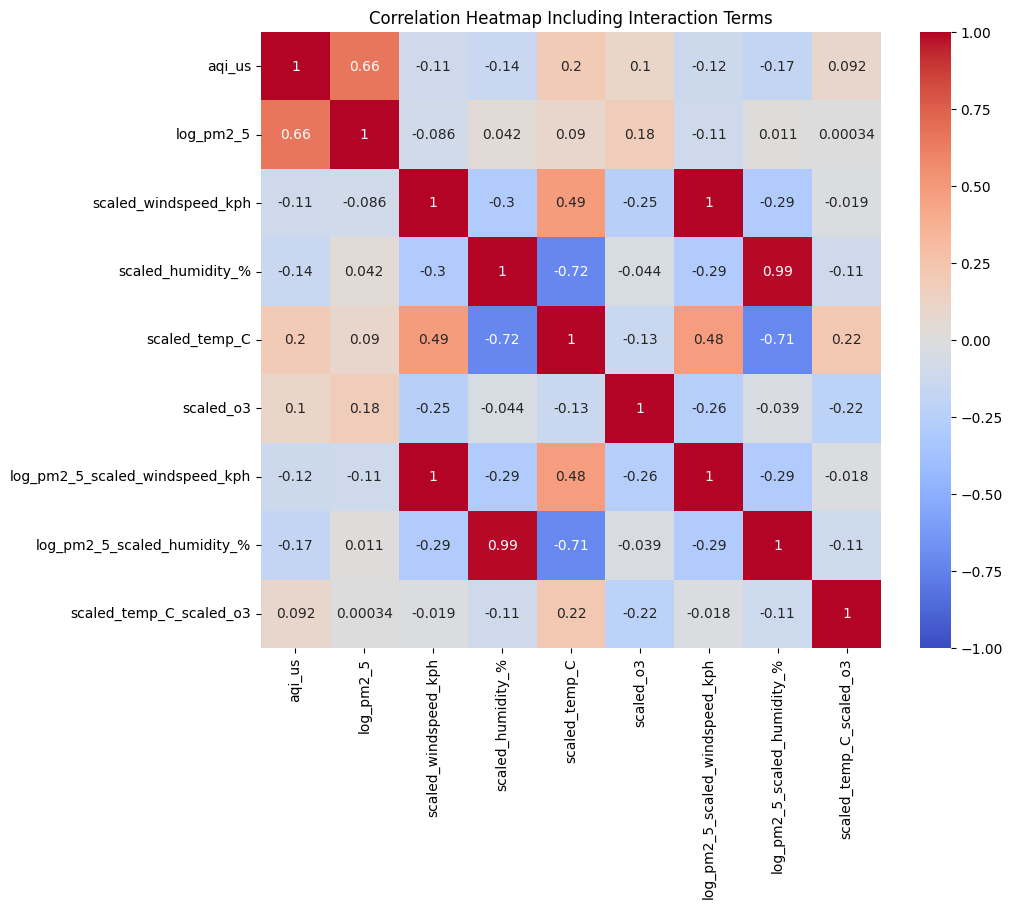

In [6]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap Including Interaction Terms')
plt.show()

Text(0, 0.5, 'AQI')

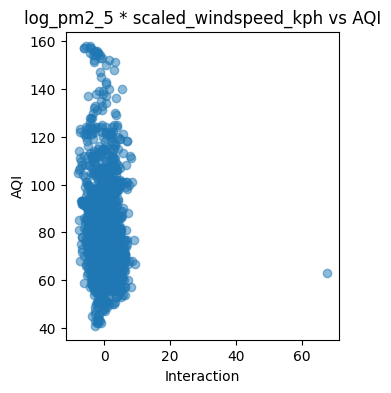

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(df['log_pm2_5_scaled_windspeed_kph'], df['aqi_us'], alpha=0.5)
plt.title('log_pm2_5 * scaled_windspeed_kph vs AQI')
plt.xlabel('Interaction')
plt.ylabel('AQI')

Text(0, 0.5, 'AQI')

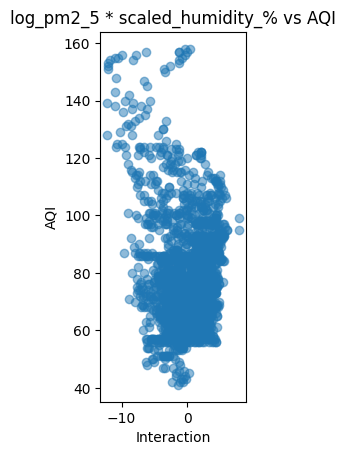

In [8]:
plt.subplot(1, 3, 2)
plt.scatter(df['log_pm2_5_scaled_humidity_%'], df['aqi_us'], alpha=0.5)
plt.title('log_pm2_5 * scaled_humidity_% vs AQI')
plt.xlabel('Interaction')
plt.ylabel('AQI')

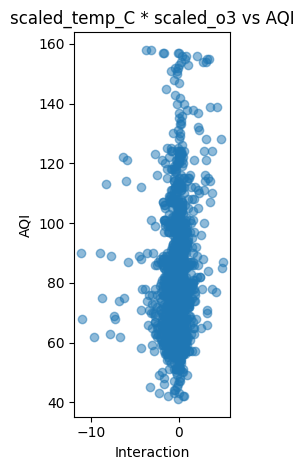

In [9]:
plt.subplot(1, 3, 3)
plt.scatter(df['scaled_temp_C_scaled_o3'], df['aqi_us'], alpha=0.5)
plt.title('scaled_temp_C * scaled_o3 vs AQI')
plt.xlabel('Interaction')
plt.ylabel('AQI')

plt.tight_layout()
plt.show()

In [24]:
# Load dataset
df = pd.read_csv("/content/full_preprocessed_aqi_weather_data_with_lags.csv")

In [26]:
# Print all column names
print("Columns in the DataFrame:", df.columns.tolist())

Columns in the DataFrame: ['datetime', 'temp_C', 'humidity_%', 'windspeed_kph', 'precip_mm', 'pm10', 'pm2_5', 'co', 'no2', 'so2', 'o3', 'log_co', 'log_pm2_5', 'log_pm10', 'log_precip_mm', 'log_so2', 'log_no2', 'scaled_temp_C', 'scaled_humidity_%', 'scaled_windspeed_kph', 'scaled_log_pm2_5', 'scaled_log_pm10', 'scaled_log_precip_mm', 'scaled_log_co', 'scaled_log_no2', 'scaled_log_so2', 'scaled_o3', 'aqi_us', 'aqi_us_lag1', 'aqi_us_lag24']


In [31]:
df.index.name
df.index[:5]

DatetimeIndex(['2025-04-01 00:00:00', '2025-04-01 01:00:00',
               '2025-04-01 02:00:00', '2025-04-01 03:00:00',
               '2025-04-01 04:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [32]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 1 for Sat/Sun

In [33]:
# Calculate correlation with aqi_us
time_features = ['hour', 'day_of_week', 'is_weekend', 'aqi_us']
time_correlation = df[time_features].corr()

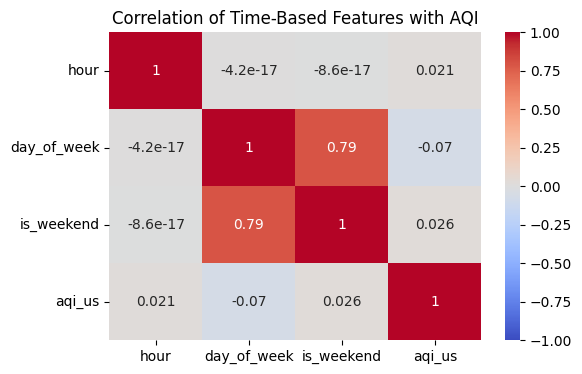

In [34]:
# Plot correlation
plt.figure(figsize=(6, 4))
sns.heatmap(time_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation of Time-Based Features with AQI')
plt.show()

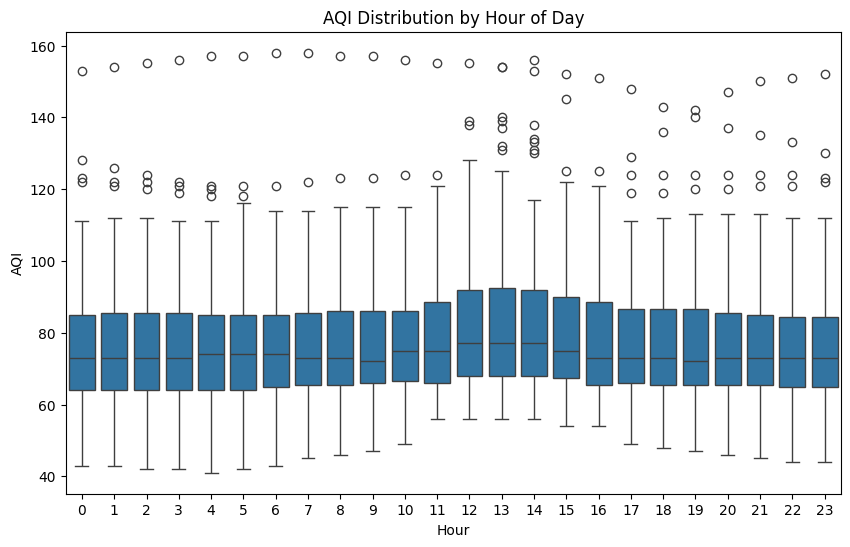

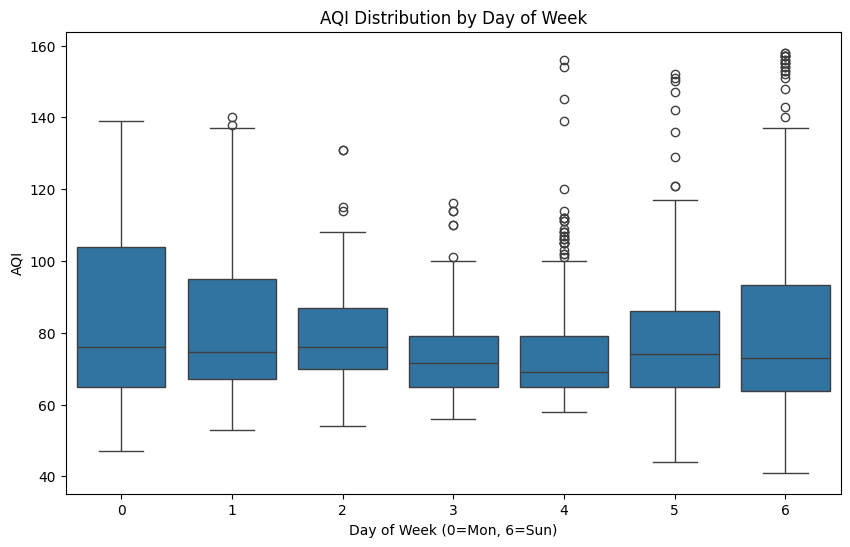

In [35]:
# Visualize diurnal pattern (box plot by hour)
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour', y='aqi_us', data=df)
plt.title('AQI Distribution by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('AQI')
plt.show()

# Optional: Weekly pattern (box plot by day of week)
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='aqi_us', data=df)
plt.title('AQI Distribution by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('AQI')
plt.show()

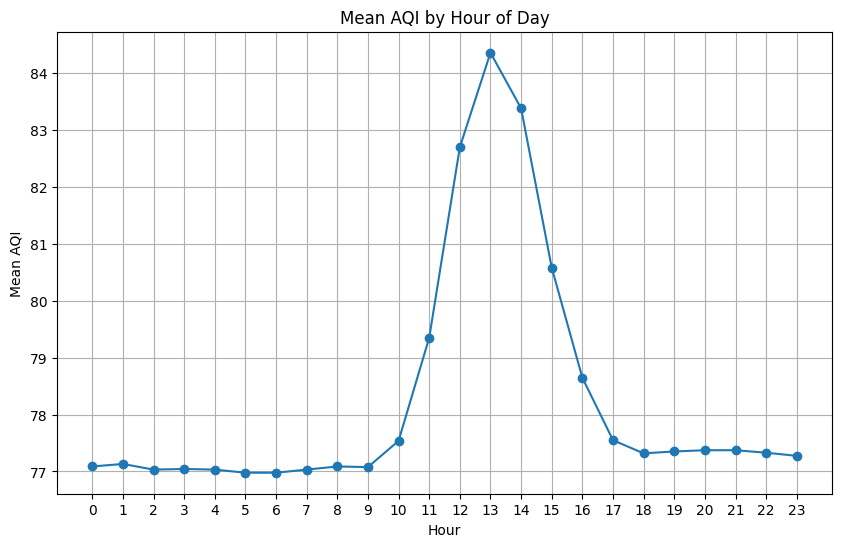

In [39]:
mean_aqi_by_hour = df.groupby('hour')['aqi_us'].mean()

# Plot the mean AQI by hour
plt.figure(figsize=(10, 6))
plt.plot(mean_aqi_by_hour.index, mean_aqi_by_hour.values, marker='o')
plt.title('Mean AQI by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Mean AQI')
plt.grid(True)
plt.xticks(range(24))  # Ensure all hours (0-23) are labeled
plt.show()

<Axes: xlabel='day_of_week', ylabel='aqi_us'>

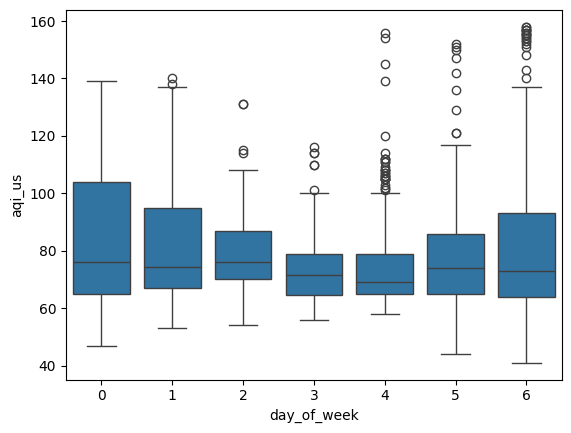

In [37]:
sns.boxplot(x='day_of_week', y='aqi_us', data=df)